\author{William~Trigos,~UIS}

In [1]:
from sympy import *
%matplotlib inline
init_printing(use_latex=True)

\begin{abstract}
En esta publicación, se describe el planteamiento de un algoritmo posicionamiento cooperativo, en el cual un grupo de dispositivos intercambian satelital observada con dispositivos cercanos, emplea información adicional a partir de una estimación de la distancia entre duplas de receptores, con el propósito de aumentar su nivel de precisión en posicionamiento.
El algoritmo presentado utiliza la solución de posicionamiento autónomo de cada dispositivo en interacción, para recalcular posición de cada uno de los dispositivos que conforman la agrupación teniendo en cuenta la información de satélites visibles en común entre los receptores de la agrupación. El planteamiento se apoya en la técnica de mínimos cuadrados ponderada (WLS), la cual tiene en cuenta la relación de distancia geométrica para establecer posicionamiento diferencial entre duplas de receptores, conformadas desde un receptor principal hacia los demás receptores que conforman el grupo.
Los resultados obtenidos muestran que, el uso de modelo un de corrección ionosférica similar para todos los receptores de una agrupación, es favorable para el planteamiento de posicionamiento cooperativo diferencial, permitiendo mejorar la precisión en posicionamiento de los dispositivos que intercambian información satelital observada con dispositivos cercanos. Adicionalmente, se ha observado que la incertidumbre en la distancia estimada entre duplas de receptores, no tiene influencia sobre índice de mejora obtenido para los escenarios y agrupaciones evaluados.
\end{abstract}

\keywords{Cooperative positioning, diferential positioning, weighted least squares, single frequency gps
receivers.}

# Introducción

Una buena parte de las aplicaciones de tecnología móvil hoy día requiere de información clara y precisa acerca de la ubicación de las personas u objetos. Aunque los receptores de bajo costo integrados en lo telefonos moviles suplen de alguna forma las necesidades de localización, exhiben niveles de error elevados para cierto tipo de aplicaciones y/o ambientes.\newline

Por otra parte, los sistemas de posicionamiento satélital son caracterizados porque tener un flujo de información es unidireccional, es decir, las señales viajan desde el satélite hacia el receptor, de forma que este ultimo dispositivo es el que tiene la responsabilidad de recolectar toda la información necesaria para  determinar su posición en forma precisa. Considerando que la capacidad de los receptores satelitales para alcanzar altos niveles de precisión, es proporcional a su costo. Por lo cual, el planteamiento de nuevas alternativas que posibiliten aumentar su nivel de precisión si elevar el costo por dispositivos es de gran interes para aplicaciones que emplean los sistemas de navegación satelitales global (GNSS).

Es conocido que el nivel de precisión para las tareas de posicionamiento, es aceptable para condiciones ideales de cielo abierto. Sin embargo, no todos los ambientes ofrecen esta posibilidad a los receptores, como es el caso de los ambientes urbanos o zonas con alta interferencia electromagnética; condiciones en las que la precisión posicionamiento de los dispositivos GNSS se ve fuertemente afectada.

Es así como el paradigma del posicionamiento cooperativo, mendiante el cual los receptores GPS, GNSS se agrupan entre si, para intercambiar información que les permita mejorar su desempeño, se es considerado un tema de interes en el ambito de los algoritmos y sistemas de posicionamiento satelital.

Una buena parte de la literatura ha sido enfocada al desarrollo de protocolos para el intercambio de información entre dispositivos, como consecuencia al auge de las redes de sensores (Wireless Sensor Networks - WNS), como es el caso de los trabajos ....

Por otra parte, la delegación de tareas lógicas desde el hardware hacia el software en dispositivos de radio frecuencia ha aumentado, en consecuencia a la flexibilidad y coste ofrecido por Software-Defined-Radio (SDR).  ha sido abordada para tareas de posicionamiento como en el caso las publicaciones de ....\newline

El contenido de esta publicación, está orientado explicitamente al planteamiento de un algoritmo de posicionamiento cooperativo, implementado bajo el enfoque de SDR mediante la librería GPSTk y el lenguaje python. Los resultados de esta publicación, podrían servir como complemento al desarrollo de infraestructuras de WSN orientadas a la mejora de la precisión en posicionamiento de dispositivos inmersos en ambientes con dificultades para recepción de señales satélitales. En la cuales, un receptor satelital podría valerse de la información obtenida por receptores cercanos y cuenten con capacidad para intercambiar información.

# Posicionamiento satelital

En esta sección se presentan conceptos relacionados con los sistemas de posicionamiento satelital, con el propósito
de tener un marco de referencia común para el lector, a partir del cual se desglosa el planteamiento del algoritmo de posicionamiento cooperativo diferencial (WLS-DCP) y que se apoya en la técnica númerica weighted least squares.


## Sistema global de posicionamiento satelital

La idea detrás de los sistemas de posicionamiento tales como GPS, puede ser resumida en:\newline

\textit{Si la distancia desde tres satélites en el espacio hasta un punto en común sobre la superficie de la tierra (un receptor GPS) es conocida, junto con la posición de los satélites al momento de la transmisión de una señal satelital hacia el receptor, la posición del receptor puede ser determinada mediante la aplicación de conceptos trigonométricos, álgebricos, sobre un sistema de coordenadas determinado \cite{Thompson_1998}}.\newline

Los sistemas de navegación satelital estan caracterizados porque el flujo de información (señales de frecuencia) es unidireccional, desde el satélite hacia el receptor, de forma que el receptor es el encargado de recibir y procesar estas señales para determinar su posición con respecto a los satelites desde los cuales obtiene información en un determinado instante de tiempo.\newline

La situación problema detrás de los sistemas de posicionamiento es, ¿Cómo conseguir las distancias a cada satélite de forma precisa?; esto con el propósito de poder determinar la posición del receptor sobre la superficie de la tierra, lo más exacto posible. Para tal fin, los modelos observacionales sirven como herramienta para describir los fenómenos físicos involucrados en el viaje de la señal, de forma que se pueda representar la distancia entre el satélite y el receptor en función de los ciclos de la señal o la duración del viaje de la señal desde el satélite hasta el receptor.

## El pseudorango y su definición

Los sistemas de posicionamiento satelital funcionan gracias a la transmisión continua de señales de radiofrecuencia a través de la ionósfera y la tropósfera. En el caso específico del sistema de posicionamiento satelital (GPS), las señales transmitidas están conformadas por dos señales de portadora, dos códigos y un mensaje de navegación. Dichas señales son adquiridas por medio de una antena, capaz de percibir las frecuencias en que son trasmitidas desde los satélites.\newline

A partir de la adquisición de estas señales, el receptor esta en capacidad de procesar y obtener un valor que representa la distancia entre su ubicación y el satélite que ha enviado la señal. A estos valores númericos se les denomina  observable de medición (observable measurement). El tipo y formato de los observables puede variar dependiendo de las caracteristicas del receptor, el fabricante o los protocolos de interoperatividad a que se acoja. Un ejemplo de ello, son los estándares \textbf{NMEA\footnote{NMEA: National Marine Electronics Association,  http://www.gpsinformation.org/dale/nmea.htm}} y \textbf{RINEX\footnote{RINEX: Receiver INdependent EXchange, https://igscb.jpl.nasa.gov/igscb/data/format/rinex211.txt}}, los mediante los cuales se representa la información obtenida por el receptor.\newline

El formato RINEX ha sido orientado para representar the raw observables, información cruda obtenida por el receptor desde cada uno de los satélites y a partir de la cual se puede obtener la posición del receptor. Por su parte, el formato NMEA es orientado a la representación de la información ya calculada por el receptor y destinada a las aplicaciones de usuario final.\newline

En cuanto a los detalles acerca de como se determina la posición de un receptor sobre la superficie terrestre, puede considerarse la interpretación geométrica del sobre el funcionamiento de GPS. Tal y como se representa en figura \ref{fig:Trilateracion}, es necesario representar el lugar geométrico de los satelites tomando como referencia sus coordenadas de origen y la distancia a la posición del receptor, para luego encontrar la intersección de los lugares geometrícos; y determinar la posición en la cual el receptor se encuentra para un determinado instante de tiempo $t$.

\begin{figure}[htp]
    \centering
    \includegraphics{Figs/Trilateracion.png}
    \caption{Figura \ref{fig:Trilateracion} Representación geométrica del concepto de trilateración.}
    \label{fig:Trilateracion}
\end{figure}

Si bien la representación de los lugares geométricos presentados en la figura \ref{fig:Trilateracion}, da lugar a pensar en dos posibles ubicaciones del receptor, un cuarto satélite permite determinar con mayor exactitud la ubicación del receptor. Es importante mencionar que, para determinadas posiciones en el planeta, un receptor esta en capacidad de observar cerca de 12 satélites en promedio ó incluso más. Esto da lugar a que el receptor cuente con mayor cantidad de información para determinar su ubicación, a su vez que aumenta el grado de incertidumbre de su ubicación, debido a que la intercepción de los lugares geométricos de todos los satélites visibles dificilmente coindiden en un solo punto, debido a que las señales que viajan desde el satélite se ven afectadas por la dispersión de la ionósfera, generando retrazos en la señal y por ende error en la determinación de la distancia existente entre cada satélite y el receptor.\newline

Es allí donde radica la importancia de representar la distancia existente entre el satélite y el receptor a través de los  modelos de observables. Un ejemplo podría ser el caso de la expresión \ref{modelo Observables}, en la cual se define el valor del observable ontenido en el receptor $r$ para un satélite $s$, como la multiplicación entre el tiempo de vuelo de la señal(Time of Fly)(TOF) y la velocidad de la luz.

\begin{equation}
  P_{r}^{s} = TOF*c = (T_r - T_s)*c
  \label{modelo Observables}
\end{equation}

\noindent Donde:

\begin{itemize}
	\item $T_r$ es un tiempo conocido por el usuario al momento de la recepción. 
	\item $T_s$ el tiempo de envío de la señal desde el satélite, que puede ser obtenido a partir de un mensaje de navegación. 
	\item $c$ es el valor de la velocidad de la luz en el vacío.\newline 
\end{itemize}

Sin embargo el modelo anterior es muy básico, como para representar los distintos fenómenos que transcurren durante el viaje de la señal a traves de la atmosfera; fenomenos que afectan a la señal e impiden determinar la distancia entre el satélite y el receptor con exactitud. Algunos modelos de observables, buscan representar de la forma más apropiada posible todos los fenómenos, lo cual aumenta significativamente su complejidad. \newline

Pero los planteamientos y desarrollos en la literatura, muestran que a su vez que es posible apoyarse en el comportamiento empirico y caracteristicas de dichos fenomenos para mitigar la complejidad de los modelos de observación. Es así como en algunos casos, se suele representar los errores asociados con los orbitales de satélites como una constante, al considerar que el cambio instantáneo en la posición del satélite, es lenta en comparación con el tiempo de muestreo de las señales satelitales en en receptor. De igual forma, el retraso ionosférico puede ser modelado por medio de constantes o funciones con tasas de cambio lentas, para representar la variación del contenido de electrones entre una medición u otra.\newline

Esta última consideración es una de las bases para planteamiento del posicionamiento diferencial, según la cual el error ionosférico es similar entre receptores cercanos y mediciones consecutivas (época a época). Estudios y documentos en la literatuca como los de \cite{el1994effect} y \cite{blewitt1997basics}, se presenta que el retraso ionosférico para múltiples receptores ubicados relativamente cerca entre sí ($d < 200[km]$), puede asumirse similar para todos ellos.

## Técnicas de posicionamiento.

Así como existe variedad de modelos de observables, existen técnicas de posicionamiento que **sustentan apoyan** su funcionamiento en ellos. Estas técnicas acotan los modelos de observable a consideraciones especiales, bajo las cuales se garantiza que el modelo de observable ofrece un mínimo margen de error en la representación de la distancia existente entre el satélite y el receptor.\newline

### Diferencial.

La ténica de posicionamiento diferencial, también conocida como modelo de posicionamiento de línea de base ó **baseline**. Es una técnica que consiste en ubicar un objeto con respecto a nodos perfectamente referenciados. Este tipo de técnica de posicionamiento es muy común entre pares de receptores, cuando la distancia que los separa no supera los 200km.\newline

\begin{figure}
    \centering
    \adjustimage{max size={0.3\linewidth}{0.3\paperheight}}{Figs/rango_satelites.png}
    \caption{Figura \ref{fig:2RX1sat} Diferenciamiento sencillo}
    \label{fig:2RX1sat}
\end{figure}

El modelo de diferenciamiento sencillo\ref{fig:2RX1sat}, comprende la operación diferencia entre los observables de dos receptores ($R_{x1}$, $R_{x2}$) durante una misma epoca (mismo tiempo) y con respecto a un satélite en común. Considerando que el modelo de observable para cada uno de los receptores es:

\begin{equation}
	\begin{aligned}
		P_{A}^{s}(t) = \rho_{A}^{s}(t) +c*\tau_{A}(t) - c*\tau^{s}(t) -d_{iono}^{s} + d_{trop}^{s} + \epsilon_{A}^{s}\\
		P_{B}^{s}(t) = \rho_{B}^{s}(t) +c*\tau_{B}(t) - c*\tau^{s}(t) -d_{iono}^{s} + d_{trop}^{s} + \epsilon_{B}^{s}
	\label{eq:Ec3}
	\end{aligned}
\end{equation}

Al aplicar la diferencia a los pseudorangos en un mismo instante de tiempo, se obtiene:

\begin{equation}
	\begin{aligned}
		\bigtriangleup P_{AB}^{s} 
		& = P_{B}^{s} - P_{A}^{s}\\
		& =(\rho_{B}^{s}-\rho_{A}^{s}) + c*(\tau_{B} - \tau_{A}) + (\epsilon_{B}^{s} - \epsilon_{A}^{s})\\
		& = \bigtriangleup \rho_{AB}^{s} + c*\bigtriangleup (\tau_{AB}) + \bigtriangleup(\epsilon_{AB}^{s})
	\label{eq:Ec4}
	\end{aligned}
\end{equation}\\

De esta forma, los términos $d_{iono}^{s}$ y $d_{trop}^{s}$ son asumidos similares para ambos receptores conforme a lo planteado en \cite{el1994effect} y \cite{blewitt1997basics}; con lo cual, las fuentes de error se anulan mutuamente.\newline

Por otra parte, un planteamiento importante es el de Rhedgecock \cite{hedgecock2014precise}. Según el cual la diferencia entre los rangos obtenidos por dos receptores a un mismo satélite en línea de vista (line of sight), es equivalente a la proyección del vector distancia entre los receptores en dirección al satélite. Siendo válido asumir que la proyección del vector distancia es similar para ambos receptores, considerando que la distancia entre los receptores y el satélite, es muy grande comparada con la distancia entre ellos.

\begin{figure}
    \centering
    \adjustimage{max size={0.5\linewidth}{0.6\paperheight}}{Figs/SD_Rhedgecock.png}
    \caption{Figura \ref{fig:SD_Rhedgecock} Geometric interpretation of the single-differencing operation based on \cite{hedgecock2014precise}}
    \label{fig:SD_Rhedgecock}
\end{figure}

Este planteamiento de Rhedgcock, es útil para el planteamiento de cosenos directores asociados con la distancia entre duplas de receptores, dentro del planteamiento de WLS-DCP que se presenta en la siguiente sección.

# El algortimo WLS-DCP

El planteamiento del Diferential cooperative positioning algorithm, se apoya en la técnica numérica de weigthed least squared WLS. De forma que la asociación de la terminología y planteamiento pueden facilitar la comprensión del algortimo y la técnica de posicionamiento propuesta en esta sección.

## Mínimos cuadrados

El planteamiento de mínimos cuadrados para posicionamiento GPS, establece un proceso de linearización al modelo no lineal del pseudorango existente entre un receptor GPS y un satélite visible desde su ubicación; con lo cual, una observación GPS obtenida por el receptor puede ser representada como:
    
\begin{equation}
\begin{aligned}
P_{obs} &= {\rho}_{model} + noise \\
        &= P(x,y,z,\tau) + \eta
\end{aligned}
\end{equation}

Al aplicar la expansión de series de taylor al modelo de pseudorango, alrededor de un punto de operación $(x_o, y_o, z_o, \tau_o)$ e ignorando los términos de orden superior y errores de truncamiento asociados, el modelo de pseudorango esta definido según la expresión \ref{eq:partials1}

\begin{equation}
\begin{aligned}
P(x,y,z,\tau) &= P(x_o,y_o,z_o,\tau_o) 
                 +(x-x_o){\frac{\partial P}{\partial x}}
                 +(y-y_o){\frac{\partial P}{\partial y}}
                 +(z-z_o){\frac{\partial P}{\partial z}}
                 +(\tau-\tau _o){\frac{\partial P}{\partial \tau}} \\
        &= P(x_o,y_o,z_o,\tau_o) 
                 +{\frac{\partial P}{\partial x}} \Delta x 
                 +{\frac{\partial P}{\partial y}} \Delta y
                 +{\frac{\partial P}{\partial z}} \Delta z 
                 +{\frac{\partial P}{\partial \tau}}\Delta \tau  \\
\end{aligned}
\label{eq:partials1}
\end{equation}

La expresión \ref{eq:partials2} hace referencia al vector de residuales, obteined from diference **bettwen** observable $P(x,y,z,\tau)$ and linearized pseudorange model $P(x_o,y_o,z_o,\tau_o)$.

\begin{equation}
\begin{aligned}
\Delta{P} &= (\frac{\partial P}{\partial x}, \frac{\partial P}{\partial y}, \frac{\partial P}{\partial t},\frac{\partial P}{\partial \tau})
            (\Delta{x} \Delta{y} \Delta{z} \Delta{\tau})^{T} \\
          &= H*\Delta{X} 
\end{aligned}
\label{eq:partials2}
\end{equation}

donde:

\begin{itemize}
\item $ \Delta P = P_{obs} - P(x_o,y_o,z_o,\tau_o)$
\item $H$ Matriz de cosenos directores
\item $ \Delta X = (\Delta x \Delta y \Delta z \Delta \tau)^{T}$
\end{itemize}

Para la cual, el método de mínimos cuadrados iterativamente calcula el valor del término $\Delta{P}$ hasta que se obtiene la mínima diferencia en $\Delta{X}$ que satisface la expresión \ref{eq:minimize}.

\begin{equation}
\begin{aligned}
     \Delta{P} = min(\Delta{P} - H*\Delta{X}) 
     \label{eq:minimize}
\end{aligned}
\end{equation}

## Proposed algorithm

El planteamiento para el algoritmo de posicionamiento cooperativo diferencial (WLS-DCP), toma como punto de partida el considerar la distancia entre dos receptores GPS como información útil para contribuir a la precisión en
posicionamiento de los receptores de los mismos. Adicionalmente, la distancia es considerada como un observable adicional, que puede ser obtenido con la ayuda de sensores de distancia ubicados en los receptores GPS o ser calculada a partir de las coordenadas de los receptores en cualquier instante de tiempo $t$, producto de la solución de posicionamiento autónomo de cada receptor. \newline

La distancia estimada por cualquiera de estas dos alternativas conlleva consigo un nivel de error asociado a su valor. El efecto de esta incertidumbre en el observable de distancia, es considerado objeto de estudio en los escenarios del apartado experimental en la sección \ref{influencia-del-error-en-el-estimado-de-distancia-entre-receptores}. \newline

Adicionalmente se tienen las siguientes consideraciones:\newline

\begin{itemize}
    \item Que la distancia entre una dupla de receptores ${d_{AB}}$ ≤ 10km.
    \item Que el número de ${n_{sats}}$ ≥ 4.
\end{itemize}

donde:

\begin{itemize}
    \item ${d_{AB}}$ la distancia entre una dupla de receptores
    \item ${n_{sats}}$ es el número de satelites visibles en común para la agrupación de receptores.
\end{itemize}


In [5]:
from sympy import *
%matplotlib inline
init_printing(use_latex=True)
%run -i ../code/WallasUtils.py
#%run -i ../code/utils.py
%run -i ../code/Wallas_symbolic_utils.py
%run -i ../code/multirover4.py

In [6]:
n_vars = 4
n_sats = 4
n, m = 2*n_sats+1, 2*n_vars#+3
# create a symbolic matrix for construct A matrix
A  = Matrix(MatrixSymbol("A",n, m))

Dist, Ad = create_distance_matrix("A", "B", "B")
Aa, Pa, Xa = create_matrix_x_receiver("A", n_sats=n_sats)
Ab, Pb, Xb = create_matrix_x_receiver("B", n_sats=n_sats)

Pma = Matrix(n_sats, 1, lambda i,j:var('P_{%s}^{(%d)}' % ('A', i+1)))
Pda = Matrix(n_sats, 1, lambda i,j:var('\Delta{P_{%s}^{(%d)}}' % ('A', i+1)))
Pmb = Matrix(n_sats, 1, lambda i,j:var('P_{%s}^{(%d)}' % ('B', i+1)))
Pdb = Matrix(n_sats, 1, lambda i,j:var('\Delta{P_{%s}^{(%d)}}' % ('B', i+1)))
Pmd = Matrix(1, 1, lambda i,j:var('d_{%s%s}' % ('A', 'B')))
Pdd = Matrix(1, 1, lambda i,j:var('\Delta{d_{%s%s}}' % ('A', 'B')))

Ps = Matrix(MatrixSymbol("P",n, 1))
Ps[:n_sats, :]   = Pma
Ps[n_sats:-1, :] = Pmb
Ps[-1] = Pmd
#Psd = Matrix(1, 1, lambda i,j:var('d_{%s%s}' % ('A', 'B')))

PD  = Matrix(MatrixSymbol("P",n, 1))
PD[:n_sats, :]   = Pda
PD[n_sats:-1, :] = Pdb
PD[-1] = Pdd

rho_a = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho_{%s}^{(%d)}}' % ('A', i+1)))
rho_b = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho_{%s}^{(%d)}}' % ('B', i+1)))

rho = Matrix(MatrixSymbol("P_comp",n, 1))
rho[:n_sats, :]   = rho_a
rho[n_sats:-1, :] = rho_b
rho[-1] = Matrix(1, 1, lambda i,j:var(' \hat{d_{%s%s}}' % ('A', 'B')))

# component asociated to position of local receiver
A[:n_sats,:n_vars:] = Aa
A[:n_sats,n_vars:] = np.zeros(np.shape(A[:n_sats,n_vars:]))

# component asociated to position of remote receiver
A[n_sats:-1,n_vars:] = Ab
A[n_sats:-1,:n_vars] = np.zeros(np.shape(A[n_sats:-1,:n_vars]))

# component asociated to distance between receivers
A[-1,:] = np.hstack((zeros(1,4), 2*Ad[:,:3], zeros(1,1)))

Pm = Matrix(MatrixSymbol("P_mod",n, 1))
Pm[:n_sats, :]   = Ps[:n_sats, :] - Pa
Pm[n_sats:-1, :] = Ps[n_sats:-1, :] - Pb
Pm[-1]           = Pmd[-1, :] - 2*Dist


Asym = A
bsym = Pm#rho

### El modelo de pseudorango asumido.

En cuanto al modelo de pseudorango $\rho_i$ empleado por el algoritmo WLS-DCP, considera que la distancia geométrica hasta el satélite visible, el error de sincronización en el reloj del receptor $\tau_a$ y los términos asociados a fenómenos ionosféricos, troposféricos, son agrupados como parte del término de error $\nu_i$.\newline 

Para efectos demostrativos y del planteamiento del algoritmo, en esta sección del documento se asume que $\nu_i=0$ para los receptores que conforman la pareja en posicionamiento cooperativo. \newline

Como caso concreto, los pseudorangos a cuatro satélites desde un receptor A serán:

In [4]:
# Paa = Matrix(n_sats, 1, lambda i,j:var('P_{%s}^{(%d)}' % ('a', i+1)))
# Pab = Matrix(n_sats, 1, lambda i,j:var('P_{%s}^{(%d)}' % ('b', i+1)))

# rho_a = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho_{%s}^{(%d)}}' % ('a', i+1)))
# rho_b = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho_{%s}^{(%d)}}' % ('b', i+1)))

nua    = Matrix(n_sats, 1, lambda i,j:var('{\\nu}_{A}^{%d}'%(i+1) ))
nub    = Matrix(n_sats, 1, lambda i,j:var('{\\nu}_{B}^{%d}'%(i+1) ))

Ecuacion(Eq(rho_a, Pa+nua))
#Ecuacion(Eq(rho_b, Pb+nub))

<IPython.core.display.Latex object>

### El observable de distancia.

Para efectos del planteamiento matemático, se considera que el error sobre este estimado de distancia es despreciable ($\epsilon_d=0$). De forma que la distancia estimada entre dos receptores $A(x_a, y_a, z_a)$ y $B(x_b, y_b, z_b)$ corresponde con la ecuación \ref{eq:d_est}. La cual, forma parte del vector de residuales planteado para el algoritmo WLS-DCP

\begin{equation}
\begin{aligned}
{d}_{AB} &= \sqrt{{\left(x_b - x_a\right)}^{2} + {\left(y_b - y_a\right)}^{2} + {\left(z_b - z_a\right)}^{2}}
\end{aligned}
\label{eq:d_est}
\end{equation}

### Matrix de cosenos directores

De igual forma al planteamiento de los vectores de residuales, se definen las expresiones para los cosenos directores a cada uno de los satélites en común para la dupla de receptores $A$ y $B$. \newline


Si se considera que los receptores $A$ y $B$ tienen visibilidad a 4 satélites en común, ubicados en posiciones $x_i, y_i, z_i$ (i=1..4). La matriz de cosenos directores $H$, será:

In [13]:
# https://tex.stackexchange.com/questions/161299/squares-in-matrix
def get_matrix_cosdir(rx_id = "a", n=4, m=4):

    simbolics = "x_%s y_%s z_%s \\tau_%s c"%(rx_id, rx_id, rx_id, rx_id)
    x,y,z,t,c = symbols(simbolics)
    X       = Matrix(m, 1, [x,y,z,t])
    A       = Matrix(n, X.shape[0], lambda i,j :var('\hat{H_{%s}^{%s}}' % (X[j], i)))
    #print type(A)
    A[:,3] = [1]*n #np.ones(4)
    #print type(A)
    if n>4:
        A[4:, 3:] = [0]*(n-4)

    return A, X

Ha, Xa = get_matrix_cosdir(rx_id="A")
Hb, Xb = get_matrix_cosdir(rx_id="B", n=5, m=4)
Hm, Xm = get_matrix_cosdir(rx_id="k", n=5, m=4)

# coseno director distancia
X = Matrix(4,1,symbols("x y z \\tau"))
Hd = Matrix(n_sats, 1, lambda i,j:var('\hat{d_{%s}^{%s}}' % ('AB', X[i]))).T
Hd[3] = 0
Hb[-1, :3] = Hd[-1, :3]

Hm, Xm = get_matrix_cosdir(rx_id="k", n=5, m=4)
Hdm = Matrix(n_sats, 1, lambda i,j:var('\hat{d_{%s}^{%s}}' % ('Ak', X[i]))).T
Hdm[3] = 0
Hm[-1, :3] = Hdm[-1, :3]

Ecuacion(Ha)
#Ecuacion(Hb[:-1,:])

<IPython.core.display.Latex object>

Donde

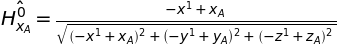

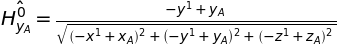

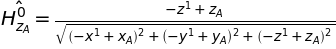

In [17]:
display(Eq(Ha[0,0], Aa[0,0])) 
display(Eq(Ha[0,1], Aa[0,1]))
display(Eq(Ha[0,2], Aa[0,2]))

Son las expresiones para las derivadas parciales del modelo de pseudorango con respecto al primer satelite en el receptor A. Lo cual, corresponde con el planteamiento presentado en las Ecuaciones \ref{eq:partials1}, \ref{eq:partials2}. De manera similar, se obtienen los cosenos directores para los demás satelites en común entre el receptor A y B.\newline

Hasta este punto, el planteamiento de las matrices de cosenos directores y el modelo de pseudorango es similar al que puede considerarse para la solución de posicionamiento autónomo, para cada receptor. \newline

Ahora el planteamiento para el algoritmo de posicionamiento cooperativo propuesto (WLS-DCP), toma en cuenta el planteamiento de \cite{hedgecock2014precise} y el observable de distancia planteado en la ecuación \ref{eq:d_est}, para modificar la estructura de la matriz de cosenos directores.

### Coseno director asociado a la distancia entre duplas receptores

Para efectos del planteamiento se considera que:

\begin{itemize}
    \item la dupla cooperativa esta conformada por los receptores A y B
    \item A es el receptor principal 
    \item B es un receptor remoto 
\end{itemize}

Entonces para la dupla conformada por A y B se tiene que, la distancia entre los receptores obedece a la distancia geométrica planteada en la ecuación \ref{eq:d_est} y que los respectivos cosenos directores en las direcciones "x, y, z" son:

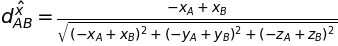

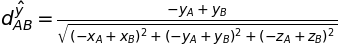

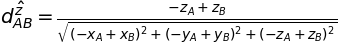

In [18]:
display(Eq(Hd[0,0], 2*Ad[0]))
display(Eq(Hd[0,1], 2*Ad[1]))
display(Eq(Hd[0,2], 2*Ad[2]))

Considerando que la posición de cualquier receptor que conforme una dupla, es calculada de forma iterativa por el algoritmo numérico WLS al dar solución al sistema de ecuaciones planteado en la matriz de cosenos directores.\newline

Al incorportar la relación geométrica adicional que representa el efecto de ligadura entre el receptor principal y el remoto, por medio del coseno director asociado a la distancia que los separa. De forma implícita, el algoritmo numérico está en capacidad de minimizar el error las coordenadas de los receptores y el error en el valor estimado de la distancia que separa a los receptores que conforman la dupla.\newline

Con lo anterior, se define que la matriz de cosenos directores en el receptor remoto $B$ y empleada por el algoritmo WLS-DCP, incorpora dentro de sí el coseno director asociado a la distancia entre el receptor principal y remoto. De esta forma, la expresión para las cosenos directores en el receptor remoto (B), será:

In [19]:
Ecuacion(Hb)

<IPython.core.display.Latex object>

## La matriz de cosenos directores cooperativa

Tomando como punto de partida las matrices de coseno directores para cada uno de los receptores que conforman la agrupación y anexando el planteamiento del coseno director para las distancias en los receptores remotos.  

se tiene que:
    
* El número de filas de la matriz de cosenos directores cooperativa es:
$$Rows = n_{sats}*n_{rx} + (n_{rx} - 1))$$

Esto debido a que los matrices de cosenos directores para los receptores remotos, tendrán siempre una fila adicional.

* El número de columnas de la matriz de cosenos cooperativa es:
$$Cols = n_{vars}*n_{rx}$$

\begin{itemize}
    \item $n_{sats}$ es el número de satélites visibles en común para la agrupación de receptores.
    \item $n_{rx}$ es el número que componen la agrupación de receptores.
    \item $n_{vars}$ es número de variables $x, y, z, \tau$ a resolver en cada receptor en interacción para el cálculo de posicionamiento cooperativo.
\end{itemize}

Para efectos demostrativos considere el caso de tres receptores en interacción ($n_{rx} = 3$) y cuatro satelites en común ($n_{rx}$ = 4), con lo cual la matriz de cosenos directores cooperativa sería:

In [20]:
from sympy.matrices import diag, Matrix, ones
Ecuacion(Matrix(diag(Ha, Hb, Hm)))

<IPython.core.display.Latex object>

Una visión generalizada de la matriz de cosenos directores cooperativa, permite deducir que cualquier variación en las coordenadas estimadas para un receptor de la agrupación, se verá reflejada en la posición de sus semejantes a través del coseno director de distancia que este conforme con los demas receptores de la agrupación.\newline

### Vector de residuales. 
De manera análoga al planteamiento del posicionamiento autónomo, el vector de residuales ∆P contempla la agrupación de los vectores de residuales autónomos para cada uno de los receptores que conforman una dupla de receptores trabajando en ámbito cooperativo. (ej: receptores a y b, son una dupla cooperativa)

In [21]:
Eq(Pda, Pma - rho_a), Eq(Pdb, Pmb - rho_b)

⎛⎡\Delta{P_{A}__{(1)}}⎤   ⎡P_{A}__{(1)} - \hat{\rho_{A}__{(1)}}⎤  ⎡\Delta{P_{B
⎜⎢                    ⎥   ⎢                                    ⎥  ⎢           
⎜⎢\Delta{P_{A}__{(2)}}⎥   ⎢P_{A}__{(2)} - \hat{\rho_{A}__{(2)}}⎥  ⎢\Delta{P_{B
⎜⎢                    ⎥ = ⎢                                    ⎥, ⎢           
⎜⎢\Delta{P_{A}__{(3)}}⎥   ⎢P_{A}__{(3)} - \hat{\rho_{A}__{(3)}}⎥  ⎢\Delta{P_{B
⎜⎢                    ⎥   ⎢                                    ⎥  ⎢           
⎝⎣\Delta{P_{A}__{(4)}}⎦   ⎣P_{A}__{(4)} - \hat{\rho_{A}__{(4)}}⎦  ⎣\Delta{P_{B

}__{(1)}}⎤   ⎡P_{B}__{(1)} - \hat{\rho_{B}__{(1)}}⎤⎞
         ⎥   ⎢                                    ⎥⎟
}__{(2)}}⎥   ⎢P_{B}__{(2)} - \hat{\rho_{B}__{(2)}}⎥⎟
         ⎥ = ⎢                                    ⎥⎟
}__{(3)}}⎥   ⎢P_{B}__{(3)} - \hat{\rho_{B}__{(3)}}⎥⎟
         ⎥   ⎢                                    ⎥⎟
}__{(4)}}⎦   ⎣P_{B}__{(4)} - \hat{\rho_{B}__{(4)}}⎦⎠

Para el caso particular de posicionamiento cooperativo, se puede apreciar que:

In [11]:
Ecuacion(Eq(PD, bsym))

<IPython.core.display.Latex object>

Adicionalmente, el término asociado con el coseno director de la distancia entre los receptores que conforman una dupla cooperativa, forma parte del vector de residuales. Por esta razón, por cada dupla de receptores que se conforma en el ámbito cooperativo, el vector de residuales tendrá una fila adicional en la cual se establece la diferencia entre el observable de distancia y su respectivo modelo algebraico.

## dimensiones y solución del minimos cuadrados

Si se considerará la solución de posicionamiento autonómo para el receptor $A$, este sistema de ecuaciones comprende un sistema de ecuaciones determinado para el cúal obtendrían soluciones fijas $x_a, y_a, z_a, \tau_a$. Sin embargo es de aclarar que, un receptor GPS hoy día puede observar en promedio 8 a 9 satélites a lo largo de un día, con lo cúal el sistema de ecuaciones anterior se convierte en un sistema sobredeterminado con múltiples soluciones, de las cuales interesa la solución para la cúal, la diferencia entre los valores calculados y los medidos desde el receptor sean mínimas; para ello, se hace uso de una técnica númerica como mínimos cuadrados para obtener soluciones númericas basadas en dicho criterio de minimizar el error del estimado de posición.

\begin{equation}
\begin{aligned}
         \hat{e} = min(\Delta{P} - H*\Delta{X}) 
\end{aligned}
\end{equation}

## Los pesos del minimo cuadrado ponderado


La matriz de pesos (weights) se construye tomando en cuenta que el coseno director establece una relación de distancia tan cual como ocurre en el posicionamiento diferencial, con lo cual se asume que el satélite con mayor elevación entre el conjunto de satélites en común, es referencia para establecer el peso de todos los elementos de la matriz de pesos, excepto para los elementos en la fila y columna en que se ubica el peso
para el termino del coseno director de la distancia, los cuales tomaran valor cero a excepción de la diagonal.\newline

El peso a asignar al término de coseno director de la distancia, se apoya en la ley exponencial presentada en el planteamiento de Rhedgecock, el coseno director de la distancia entre una dupla de receptores, es equivalente a la proyección del vector unitario de la distancia en dirección al satélite en común entre los receptores. 

$$\epsilon = 2.476x{10}^{-8}{x}^2$$

Con lo cual, se considera que el peso para la relación geométrica de ligadura establecida mediante el cosenos director de distancia, esta relacionada con la ongitud de baseline entre los receptores y adicionalmente es es válida para todo el conjunto de satélites en común que existe entre cada dupla cooperativa conformada entre el receptor principal y los receptores remotos.


\section{Desarrollo experimental}\label{sec:Experiments}

En este capítulo se presentan los distintos escenarios sobre los cuales se evaluará el posicionamiento cooperativo en pro de determinar si este contribuye a mejorar la precisión en posicionamiento de receptores de una frecuencia (single-frequency GPS receivers), trabajando en modo cooperativo. \newline

En dichos escenarios se plantea el uso de diferentes modelos de corrección ionosférica e incertidumbre en el observable de distancia entre duplas de receptores, para evaluar el nivel de impacto de estas variables sobre el nivel de precisión en posicionamiento de los receptores que conforman una agrupación.\newline

Para determinar en que escenarios el posicionamiento diferencial cooperativo (diferential cooperative positioning), permite mejorar la precisión en posicionamiento de un receptor GPS con respecto a su posicionamiento en modo autónomo.\newline


# Indice de mejora

Para determinar el error promedio de los receptores móviles operando en modo cooperativo y su mejora en el nivel de precisión con respecto al posicionamiento autónomo. La métrica \emph{indice de mejora} se define como:

\textit{El promedio de la diferencia entre el error de posicionamiento en modo autónomo ${E}_{stand}$ y modo cooperativo ${E}_{coop}$, para cada uno de los receptores de una agrupación; para un conjunto de $n$ observaciones durante un día GPS.}

Es importante mencionar que:

* Se denomina agrupación de receptores, a un conjunto de receptores que pueden ver satélites en común; a partir de los cuales se obtienen los datos para llevar a cabo la ejecución del algoritmo de posicionamiento cooperativo diferencial.
* El error promedio cooperativo ($\hat{\Delta{E}}_{stand}^{coop}$), es obtenido de promediar la diferencia entre los errores de posicionamiento autónomo ${E}_{stand}$ y cooperativo ${E}_{coop}$ de un receptor GPS, durante un periodo de tiempo. (ej: $n$ observaciones en un día GPS))
* El indice de mejora ${I}_{pos}$, hace referencia a que tanto mejora la precisión en posicionamiento de un receptor GPS, cuando intercambia información satelital con sus vecinos cercanos.


## El error promedio cooperativo 

El promedio de la diferencia entre el error de posicionamiento en ámbito cooperativo y autónomo $\hat{\Delta{E}}_{stan}^{coop}$ , se obtiene de considerar que cada receptor de la agrupación tiene $n$ muestras de observaciones GPS en común con sus vecinos. Con lo cual el valor de $\hat{\Delta{E}}_{stan}^{coop}$, para cada receptor puede ser obtenido mediante:

\begin{equation}
    {\hat{\Delta{E}}_{stan}^{coop}} = \frac{\sum_{i=1}^{n} {({E(i)}_{stand}} - {E(i)}_{coop})}{n}
\end{equation}

## El índice de mejora

A partir del valor $\hat{\Delta{E}}_{stan}^{coop}$ de cada uno de los receptores que conforman una agrupación de tamaño ($m$) receptores cooperativos, se obtiene el indice de mejora (${I}_{pos}$), a partir del promedio de los errores promedios cooperativos para cada agrupación $\bar{\Delta{E}}_{stan}^{coop}$. 

El valor de (${I}_{pos}$), sirve como indicador de que tanto mejora la precisión en posicionamiento de un receptor trabajando en ambito cooperativo con respecto a su nivel de error en posicionamiento autonomo.\newline

El indice de mejora se define como:

\begin{equation}
    {I}_{pos} = \frac{\sum_{j=1}^{m} ({\hat{\Delta{E(j)}}_{stan}^{coop}} - \bar{\Delta{E(j)}}_{stan}^{coop})}{m}
\end{equation}

De manera que, si el valor de $({I}_{pos}>0)$ es positivo indicará que el error de posicionamiento en modo autónomo es mayor, comparado con el obtenido en ámbito cooperativo. Entonces, los escenarios para los cuales el indice de mejora es positivo, se consideran escenarios favorables para el algoritmo de posicionamiento cooperativo diferencial planteado en esta publicación.\newline

Para los casos desfavorables a la hipotesis, se consideran las condiciones y escenarios bajo los cuales el indice $({I}_{pos}<0)$ es negativo

# Los escenarios de simulación

El diseño experimental contempla el uso de observables C1 o P1. Adicionalmente, la distancia entre cada pareja de receptores es un considerada un observable al que se le puede atribuir nivel de ruido en su medición. De forma que, se han definido un conjunto de cuatro escenarios en los cuales se contempla la variación del modelo ionosférico y el nivel de error en el observable d, para evaluar su nivel de impacto sobre la precisión en posicionamiento de los receptores que trabajan en ámbito de posicionamiento cooperativo.\newline

Para lo cual se ha considerado evaluar los días GPS 10, 11, 12,13 del año 2017, de forma que se apreciar si la variación ionosférica tiene impacto sobre la solución de algoritmo.\newline


In [6]:
import numpy as np
import gpstk
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML, Image
#display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
%run -i ../code/multirover4.py
parejas_kmz = {}
parejas_kmz[1] = ("ljrn", "p553", "p554", "fzhs",)
parejas_kmz[2] = ("CN20", "TGPM",)
parejas_kmz[3] = ('TGMX', 'UNPM',)

## Variación del modelo de corrección ionosférico

Los modelos ionosféricos y combinaciones de cada uno de los escenarios son: 

#### Escenario 1: sin corrección ionosférica
Para este escenario tanto el receptor principal como los remotos no emplean ningún modelo de corrección para mitigar el efecto de la ionosféra.

#### Escenario 2: Diferencial #1
* receptor principal: con corrección ionosférica de doble frecuencia
* receptores remotos: ningún modelo de corrección
Las condiciones representadas en este escenario serían similares a las de un sistema posicionamiento RTK. En el cual un conjunto de receptores se suple de la información disponible desde un receptor que cuenta con correcciones de doble frecuencia para mejorar su posicionamiento. 

#### Escenario 3: Diferencial #2
* receptor principal: con corrección ionosférica de doble frecuencia
* receptores remotos: con corrección ionosférica modelo klobuchar
A diferencia del escenario diferencial #2, las condiciones de este escenario implican que los receptores remotos manejan el modelo de corrección de frecuencia sencilla klobuchar.

#### Escenario 4: klobuchar
* receptor principal: con corrección ionosférica modelo klobuchar
* receptores remotos: con corrección ionosférica modelo klobuchar
Las condiciones de este escenario implican que todos los receptores emplean el modelo de corrección de frecuencia sencilla klobuchar.
**ECUACIÖN**

#### Escenario 5: Diferencial #3
* receptor principal: con corrección ionosférica de doble frecuencia
* receptores remotos: con corrección ionosférica modelo standard
A diferencia del escenario diferencial #2, las condiciones de este escenario implican que los receptores remotos manejan el modelo de corrección de frecuencia sencilla klobuchar.

#### Escenario 6: Standard
* receptor principal: con corrección ionosférica modelo standard
* receptores remotos: con corrección ionosférica modelo standard
Las condiciones de este escenario implican que todos los receptores emplean el modelo de corrección standard
**ECUACIÖN**

#### Escenario 7: Diferencial #4
* receptor principal: con corrección ionosférica de doble frecuencia
* receptores remotos: con corrección ionosférica modelo Cascaron Series de taylor
A diferencia del escenario diferencial #3, las condiciones de este escenario implican que los receptores remotos manejan el modelo Cascaron Series de taylor.

#### Escenario 8: Cascaron Series de taylor
* receptor principal: con corrección ionosférica modelo Cascaron Series de taylor
* receptores remotos: con corrección ionosférica modelo Cascaron Series de taylor
Las condiciones de este escenario implican que todos los receptores emplean el modelo de Cascaron Series de taylor.
**ECUACIÖN**



## Variación en el observable de distancia

Para todos los escenarios anteriores se evalua simultaneamente, el impacto que tiene la distancia y la sensibilidad de su medición en la precisión de posicionamiento de los receptores que trabajan en modo cooperativo.\newline

\begin{itemize}
    \item Error en observable de distancia $\epsilon_d = 0\%$
    \item Error en observable de distancia $\epsilon_d = 5\%$
    \item Error en observable de distancia $\epsilon_d = 10\%$
\end{itemize}

# Ejecución de los experimentos

En esta sección se presenta el análisis y valores de los indices de mejora obtenidos para cada uno de los escenarios sobre los cuales se evaluó el algoritmo de posicionamiento cooperativo diferencial. 

Los conjuntos de estaciones empleados para evaluar cada uno de los escenarios anteriores será:


In [7]:
df_stations = pd.DataFrame(parejas_kmz.items(), index=parejas_kmz.keys(), columns=["Group", "Receivers"])
df_stations = df_stations.set_index("Group")
df_stations = df_stations.assign(Size_group = df_stations['Receivers'].apply(lambda x: len(x)))
df_stations = df_stations.assign(Location = ["USA", "Panama", "Mexico"]) #Antillas"

#df_stations

Tabla = df_stations.to_latex().encode('ascii','ignore')
label = "tabla_escenarios"
caption = "Estaciones utilizadas para el estudio."

#display(df_stations)
strLatex2="""
            \\begin{table}[h!]
            \\begin{minipage}{\linewidth}
            \\begin{center}
            %s
            \\caption{Tabla \\ref{tab:%s} %s}
            \\label{tab:%s}
            \\end{center}
            \\end{minipage}
            \\end {table}
            """%(df_stations.to_latex() , label, caption, label)
display(Latex(latex(strLatex2, mode="inline")))

<IPython.core.display.Latex object>

En la siguiente figura se puede apreciar una visión geográfica de donde se encuentran las agrupaciones utilizadas.\newline

In [8]:


filename = "../Documento/images/Red_Analisis.png"
pdf_name = "Red_Analisis"
figlabel = pdf_name
figcaption = "Ubicación de las estaciones empleadas para el estudio."

import matplotlib.image as mpimg
img = mpimg.imread(filename)
plt.imshow(img, extent=[0,100,0,1], aspect='auto')
save(pdf_name, ext="pdf", close=True, verbose=False)

#display(Image(filename),Caption(pdf_name, figlabel, str(figcaption), size=(.75, 0.35)))

In [12]:
%run -i ../code/Paper.py

In [14]:
Archivo_Analisis = "../../repo/Desarrollo_Actual/Resultados/Analisis_weight_010['8.1', '8.2', '8.3'].h5"
indices = ['stations', 'gps_day', 'Enviroment', 'scenario']
columnas = ["improve_by_agrupation", "improve_by_station"]
bk1, df1 = Analisis(Archivo_Analisis, indices, columnas, 1)

## Influencia del error en el estimado de distancia entre receptores

El indice de mejora tiene un comportamiento estable ante la variación en el nivel de error en la distancia  estimada entre el receptor principal y los demás receptores.\newline 

In [15]:
estaciones = ['tgmx,unpm', 'cn20,tgpm']#, 'ljrn,p553,p554,fzhs']
indices_groupby = ["stations", "gps_day","Enviroment"]

df = graficaScatter(df1, estaciones, range(5), profundidad=4)
df = df[df.index.get_level_values("gps_day").isin(["10"])]

label = "variacion_distancia"
caption = "Comportamiento constante del indice de mejora, ante la variacion en el observable de distancia."


strLatex2="""
            \\begin{table}[h!]
            \\begin{minipage}{\linewidth}
            \\begin{center}
            %s
            \\caption{Tabla \\ref{tab:%s} %s}
            \\label{tab:%s}
            \\end{center}
            \\end{minipage}
            \\end {table}
            """%(df.to_latex() , label, caption, label)
display(Latex(latex(strLatex2, mode="inline")))

<IPython.core.display.Latex object>

\hfill 
Como puede apreciarse en las tablas, la variación en el indice de mejora para cualquiera de estos escenarios es mínima o despreciable(negligible). Sin embargo, esto puede deberse a que las distancia promedio para la agrupación lnrn, p553, p554 y fzhs es alrededor de . Mientras que para las parejas cn20, tgmp y unpm,tgmx no superan los 200m.


Con lo anterior se concluye que el nivel de error en la distancia conformada entre las duplas de receptores, no tiene influencia significativa en el indice de mejora planteado en la sección \ref{el-uxedndice-de-mejora}. Por lo tanto, el análisis se centrará en evaluar que tiene la variación del modelo ionóferico empleado por los receptores, considerando que las estaciones empleadas para este estudio se encuentran sobre el caribe donde el el margen de error asociado al retraso inosférico es significativo.

## Influencia del modelo ionosférico

En la tabla \ref{tab:tab_resultados} se presenta un consolidado del indice de mejora obtenido para cada uno de los escenarios en los que se varia el modelo ionosférico empleado por cada receptor. Es importante mencionar, que se ha tomado como referencia un receptor principal y un conjunto de receptores remotos dentro de cada agrupación evaluada, de forma que el receptor principal podría ser cualquiera de los receptores que conformen el grupo cooperativo.\newline

Sin embargo, para efectos de este estudio se han considerado escenarios para los cuales los receptores remotos emplean el mismo modelo ionosférico en algúnos casos.

In [16]:
#--------------------------------------------
estaciones = ['cn20,tgpm', 'tgmx,unpm', 'ljrn,p553,p554,fzhs']
indices_groupby = ["stations", "gps_day","Enviroment"]

df = graficaScatter(df1, estaciones, range(8+1), profundidad=len(indices_groupby))
#display(df)
data = df.stack()
# saca el promedio de todos los subescenarios
data = data.groupby(level=indices_groupby).sum().unstack('stations').unstack('gps_day')
# Marcar estilo de los escenarios desfavorables
#data_mask = data.style.apply(color_negative)

#display(data_mask)

strLatex2="""
            \\begin{table}[h!]
            \\begin{minipage}{\linewidth}
            \\begin{center}
            %s
            \\caption{Tabla \\ref{tab:%s} %s}
            \\label{tab:%s}
            \\end{center}
            \\end{minipage}
            \\end {table}
            """%(data.to_latex(), "tab_resultados", "Indices de mejora obtenidos en los experimentos.", "tab_resultados")
display(Latex(latex(strLatex2, mode="inline")))

<IPython.core.display.Latex object>

In [17]:
dat = data.copy()
dat[dat<dat.quantile(0.15)]=np.nanmin(dat.iloc[:,1].values)

import seaborn as sns

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
sns.set(font_scale=1.4)
sns_plot = sns.heatmap(dat, annot=True, ax=ax)
ax = sns_plot.get_figure()
plt.close()

fig.savefig("./Resultados.pdf", format='pdf', bbox_inches='tight')

strLatex2="""
    \\begin{figure}
        \\begin{center}
        	\\adjustimage{max size={%s\linewidth}{%s\paperheight}}{%s}
            \\caption{Figura \\ref{fig:%s} %s}
            \\label{fig:%s}
        \\end{center}
    \\end{figure}"""%(".7", ".7", "Resultados.pdf", "fig_res", "HeatMap of improvement index for different scenarios.", "fig_res")
display(Latex(latex(strLatex2, mode="inline")))

<IPython.core.display.Latex object>

# Conclusiones
\hfill
Apoyados en la figura \ref{fig:fig_res} la cúal sintetiza los resultados obtenidos para el indice de mejora en los escenarios propuestos para este estudio, se puede concluir que:

* la corrección ionosférica de doble frecuencia en el escenario Diferential cooperative positioning es desfavorable, ya que solo la agrupación $tgmx, unpm$ lográ mejorar su nivel de precisión empleando este tipo de configuracíón.

* la combinación de corrección ionosférica de doble frecuencia y modelo ionósferico klobuchar, resulta ser el escenario mas desfavorable para Diferential cooperative positioning. En los escenarios 3 y 4, cerca de un 95% de los resultados de indice de mejora fueron valores negativos, inclusive outliers producto de problemas de convergencia en el algoritmo ante la alta varianza en el vector de residuales, que podría esta asociada a la diferencia que existe entre los dos modelos de corrección ionósferica,

* para los escenarios en los que se plantea la corrección de doble frecuencia sobre el receptor principal, como es el caso de los ambientes 5 y 7. En los cuales 2 de las 3 agrupaciones no logran mejorar precisión en posicionamiento. Justamente la agrupación $ljrn,p553,p554,fzhs$, tiene como desventaja ser la agrupación con mayor distancia promedio entre duplas de receptores, esto hace implica un mayor nivel de error en el estimado de la longitud de linea de dase (baseline) obtenido por el algoritmo WLs, tras cada iteración. Tan solo la pareja $tgmx, unpm$, presenta indices de mejora positivos. esto podría estar asociada a dos factores; el primero de ellos es la distancia entre los receptores de esta dupla, la cual no supera los 150 m. el segundo factor importante es la ubicación y visibilidad de satélites en común de esta agrupación, lo cúal implica contar con más información para la tarea de posicionamiento.

* los escenarios más favorables para Diferential cooperative positioning son los escenarios 1, 6 y 8. Estos escenarios tiene una caracteristica en particular, para estos escenarios se tiene que los modelos de corrección ionosférica empleados en el receptor principal y remotos es el mismo, es decir, el indice de mejora para estos escenarios esta **intimamente** relacionado con el estimado de distancia.

* Es importante resaltar que la variación en este observable no afecta el indice, según lo expuesto en la sección \ref{influencia-del-error-en-el-estimado-de-distancia-entre-receptores}, para variaciones del 0%, 5% y 10% de la distancia real entre duplas la variación en el indice de mejora es imperceptible.